In [1]:
#import libraries
import pandas as pd
import numpy as np   #pandas is built on numpy
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, roc_auc_score, precision_score,recall_score, f1_score, confusion_matrix, accuracy_score)
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
import time
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier

####dataframe: group of multiple series (column) linked by the same index (rows)

## Reading in data

In [2]:
file_paths={
    'Sat':'TestbedSatJun12Flows.csv',
    'Sun':'TestbedSunJun13Flows.csv',
    'Mon':'TestbedMonJun14Flows.csv',
    'Tue':'TestbedTueJun15Flows.csv',
    'Wed':'TestbedWedJun16Flows.csv',
    'Thu':'TestbedThuJun17Flows.csv'
} #dictionary
frames=[]
for day,path in file_paths.items():
    df_2012=pd.read_csv(path)
    df_2012['day']=day
    frames.append(df_2012)

df=pd.concat(frames,ignore_index=True)
pd.set_option('display.max_columns',None)

## Subsetting session-level data

In [3]:
session_df=['totalSourceBytes','totalDestinationBytes','totalSourcePackets','totalDestinationPackets','direction','sourceTCPFlagsDescription',
    'destinationTCPFlagsDescription','protocolName','sourcePort','destinationPort'] #drop time because it does not help the model according to SHAP
                                                                                    #analysis performed and over 83% are zero duration sessions
df=df[session_df+['Label','day']] #keeping day for more analysis later
df=df.copy()

## Engineering features

In [4]:
#packet ratio
df['packet_ratio']=df['totalSourcePackets']/df['totalDestinationPackets'].replace(0,np.nan)
df['packet_ratio']=df['packet_ratio'].fillna(0).clip(upper=10)

#byte ratio
df['byte_ratio']=df['totalSourceBytes']/df['totalDestinationBytes'].replace(0,np.nan)
df['byte_ratio']=df['byte_ratio'].fillna(0).clip(upper=10)

#average packet size source
df['avg_packet_size_src']=df['totalSourceBytes']/df['totalSourcePackets'].replace(0,np.nan)
df['avg_packet_size_src']=df['avg_packet_size_src'].fillna(0).clip(upper=1500)

#average packet size destination
df['avg_packet_size_dst']=df['totalDestinationBytes']/df['totalDestinationPackets'].replace(0,np.nan)
df['avg_packet_size_dst']=df['avg_packet_size_dst'].fillna(0).clip(upper=1500)

#bytes per packet 
df['bytes_per_packet'] = (df['totalSourceBytes'] + df['totalDestinationBytes'])/(df['totalSourcePackets'] + df['totalDestinationPackets']).replace(0, np.nan)
df['bytes_per_packet'] =df['bytes_per_packet'].fillna(0).clip(upper=1500)


## Inspecting data

In [5]:
df.head()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,direction,sourceTCPFlagsDescription,destinationTCPFlagsDescription,protocolName,sourcePort,destinationPort,Label,day,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst,bytes_per_packet
0,128,64,2,1,L2R,"F,A","F,A",tcp_ip,22441,80,Normal,Sat,2.000000,2.000000,64.000000,64.000000,64.000000
1,128,64,2,1,L2R,"F,A","F,A",tcp_ip,22445,80,Normal,Sat,2.000000,2.000000,64.000000,64.000000,64.000000
2,128,64,2,1,L2R,"F,A","F,A",tcp_ip,22444,80,Normal,Sat,2.000000,2.000000,64.000000,64.000000,64.000000
3,2938,49570,27,76,L2L,"S,R,P,A","S,P,A",tcp_ip,3248,22,Normal,Sat,0.355263,0.059270,108.814815,652.236842,509.786408
4,644,2315,7,5,L2R,"S,P,A","S,P,A",tcp_ip,1867,80,Normal,Sat,1.400000,0.278186,92.000000,463.000000,246.583333


In [6]:
df.tail()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,direction,sourceTCPFlagsDescription,destinationTCPFlagsDescription,protocolName,sourcePort,destinationPort,Label,day,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst,bytes_per_packet
2071652,426,808,5,5,L2R,"F,S,P,A","F,S,P,A",tcp_ip,4077,80,Normal,Thu,1.000000,0.527228,85.200000,161.600000,123.400000
2071653,2526,92483,38,65,L2R,"F,S,P,A","F,S,P,A",tcp_ip,4078,80,Normal,Thu,0.584615,0.027313,66.473684,1422.815385,922.417476
2071654,310,130,3,2,L2R,"S,P,A","S,A",tcp_ip,4079,80,Normal,Thu,1.500000,2.384615,103.333333,65.000000,88.000000
2071655,426,808,5,5,L2R,"F,S,P,A","F,S,P,A",tcp_ip,4080,80,Normal,Thu,1.000000,0.527228,85.200000,161.600000,123.400000
2071656,624,7431,8,8,L2R,"S,P,A","S,P,A",tcp_ip,4081,80,Normal,Thu,1.000000,0.083973,78.000000,928.875000,503.437500


In [7]:
df.dtypes

totalSourceBytes                    int64
totalDestinationBytes               int64
totalSourcePackets                  int64
totalDestinationPackets             int64
direction                          object
sourceTCPFlagsDescription          object
destinationTCPFlagsDescription     object
protocolName                       object
sourcePort                          int64
destinationPort                     int64
Label                              object
day                                object
packet_ratio                      float64
byte_ratio                        float64
avg_packet_size_src               float64
avg_packet_size_dst               float64
bytes_per_packet                  float64
dtype: object

In [8]:
df.describe()

,totalSourceBytes,totalDestinationBytes,totalSourcePackets,totalDestinationPackets,sourcePort,destinationPort,packet_ratio,byte_ratio,avg_packet_size_src,avg_packet_size_dst,bytes_per_packet
count,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06,2.071657e+06
mean,2.460947e+03,3.448911e+04,1.984019e+01,3.030068e+01,1.413759e+04,1.882091e+03,8.963556e-01,3.627887e-01,8.485923e+01,4.857326e+02,3.157876e+02
std,7.517785e+05,1.187177e+06,6.679018e+02,9.834982e+02,2.014297e+04,8.623280e+03,4.704839e-01,5.328998e-01,3.443784e+01,4.493927e+02,2.660675e+02
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.400000e+01
25%,2.560000e+02,4.190000e+02,3.000000e+00,2.000000e+00,2.302000e+03,8.000000e+01,6.600000e-01,5.170012e-02,7.250000e+01,1.418000e+02,1.190000e+02
50%,4.420000e+02,1.177000e+03,6.000000e+00,5.000000e+00,3.744000e+03,8.000000e+01,1.000000e+00,2.051937e-01,7.853333e+01,2.920000e+02,1.953846e+02
75%,8.450000e+02,7.338000e+03,1.000000e+01,1.100000e+01,1.699300e+04,8.000000e+01,1.000000e+00,4.801085e-01,9.000000e+01,7.860000e+02,4.580580e+02
max,7.632776e+08,1.254005e+09,5.147940e+05,8.722240e+05,6.553500e+04,6.553500e+04,1.000000e+01,1.000000e+01,1.500000e+03,1.500000e+03,1.500000e+03


In [9]:
#Create directory
os.makedirs("eda_outputs", exist_ok=True)

#Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_cols]

#Calculate skewness
skewness = df_numeric.skew().sort_values(ascending=False)

skewness.to_csv("eda_outputs/skewness_before_log.csv")
print("Skewness stats saved")

# Identify highly skewed columns
skew_threshold = 1
skewed_cols = skewness[abs(skewness) > skew_threshold].index.tolist()
print("Highly skewed columns (|skew| > 1):", skewed_cols)

# Sample for plot 
sample_size = 10000
df_plot_sample = df.sample(n=min(sample_size, len(df)), random_state=42)

# Visualise before transformation
for col in skewed_cols:
    sns.histplot(df_plot_sample[col].dropna(), kde=True)
    plt.title(f"Before log1p transform: {col}")
    plt.savefig(f"eda_outputs/before_log_{col}.png")
    plt.close()

# Log transformation
df_log_transformed = df.copy()
transformed_cols = []

for col in skewed_cols:
    col_data = df_log_transformed[col]
    if col_data.min() < 0:
        print(f"Skipping {col} (contains negative values)")
        continue
    df_log_transformed[col] = np.log1p(col_data)
    transformed_cols.append(col)

# Sample for plot
df_log_sample = df_log_transformed.sample(n=min(sample_size, len(df)), random_state=42)

# Visualise after transformation
for col in transformed_cols:
    sns.histplot(df_log_sample[col].dropna(), kde=True)
    plt.title(f"After log1p transform: {col}")
    plt.savefig(f"eda_outputs/after_log_{col}.png")
    plt.close()

# Save transformed column names
pd.Series(transformed_cols, name="log1p_transformed_columns").to_csv("eda_outputs/log1p_transformed_columns.csv", index=False)
print("Transformation complete")

Skewness stats saved
Highly skewed columns (|skew| > 1): ['totalSourceBytes', 'totalDestinationBytes', 'totalSourcePackets', 'totalDestinationPackets', 'avg_packet_size_src', 'byte_ratio', 'destinationPort', 'packet_ratio', 'sourcePort', 'bytes_per_packet']
Transformation complete


In [10]:
missing_counts=df.isnull().sum()
print("Missing counts per column: \n",missing_counts)

Missing counts per column: 
 totalSourceBytes                       0
totalDestinationBytes                  0
totalSourcePackets                     0
totalDestinationPackets                0
direction                              0
sourceTCPFlagsDescription         430943
destinationTCPFlagsDescription    493422
protocolName                           0
sourcePort                             0
destinationPort                        0
Label                                  0
day                                    0
packet_ratio                           0
byte_ratio                             0
avg_packet_size_src                    0
avg_packet_size_dst                    0
bytes_per_packet                       0
dtype: int64


In [11]:
# Missing by Label
total_by_label = df.groupby('Label').size()
missing_by_label = df[df.isnull().any(axis=1)].groupby('Label').size()

missing_summary_label = pd.DataFrame({'total_count': total_by_label,'missing_count': missing_by_label,})
missing_summary_label['missing_percentage'] = (missing_summary_label['missing_count'] / missing_summary_label['total_count'] * 100).round(2)

print("Missing values summary by Label:")
print(missing_summary_label.fillna(0))

# Missing by Day
total_by_day = df.groupby('day').size()
missing_by_day = df[df.isnull().any(axis=1)].groupby('day').size()

missing_summary_day = pd.DataFrame({'total_count': total_by_day,'missing_count': missing_by_day,})
missing_summary_day['missing_percentage'] = (missing_summary_day['missing_count'] / missing_summary_day['total_count'] * 100).round(2)

print("\nMissing values summary by Day:")
print(missing_summary_day.fillna(0))


Missing values summary by Label:
        total_count  missing_count  missing_percentage
Label                                                 
Attack        68910           2351                3.41
Normal      2002747         494411               24.69

Missing values summary by Day:
     total_count  missing_count  missing_percentage
day                                                
Mon       171380          54207               31.63
Sat       133193          42507               31.91
Sun       275528          62810               22.80
Thu       397595          86681               21.80
Tue       571698         149848               26.21
Wed       522263         100709               19.28


## Encoding categorical columns

In [12]:
cat_cols=['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription','protocolName']
for col in cat_cols:
    df[col] = df[col].fillna("UNKNOWN")

label_encoders = {}
label_mappings = {}

for col in cat_cols:
    le = LabelEncoder()
    df[ col] = le.fit_transform(df[col])
    label_encoders[col] = le
    label_mappings[col] = dict(zip(le.transform(le.classes_), le.classes_))

for col, mapping in label_mappings.items():
    mapping_df = pd.DataFrame(list(mapping.items()), columns=['Code', 'Category'])
    mapping_df.to_csv(f"eda_outputs/{col}_label_mapping.csv", index=False)

print(df.dtypes)
print("Mappings completed.")

totalSourceBytes                    int64
totalDestinationBytes               int64
totalSourcePackets                  int64
totalDestinationPackets             int64
direction                           int32
sourceTCPFlagsDescription           int32
destinationTCPFlagsDescription      int32
protocolName                        int32
sourcePort                          int64
destinationPort                     int64
Label                              object
day                                object
packet_ratio                      float64
byte_ratio                        float64
avg_packet_size_src               float64
avg_packet_size_dst               float64
bytes_per_packet                  float64
dtype: object
Mappings completed.


## Correlation matrix 

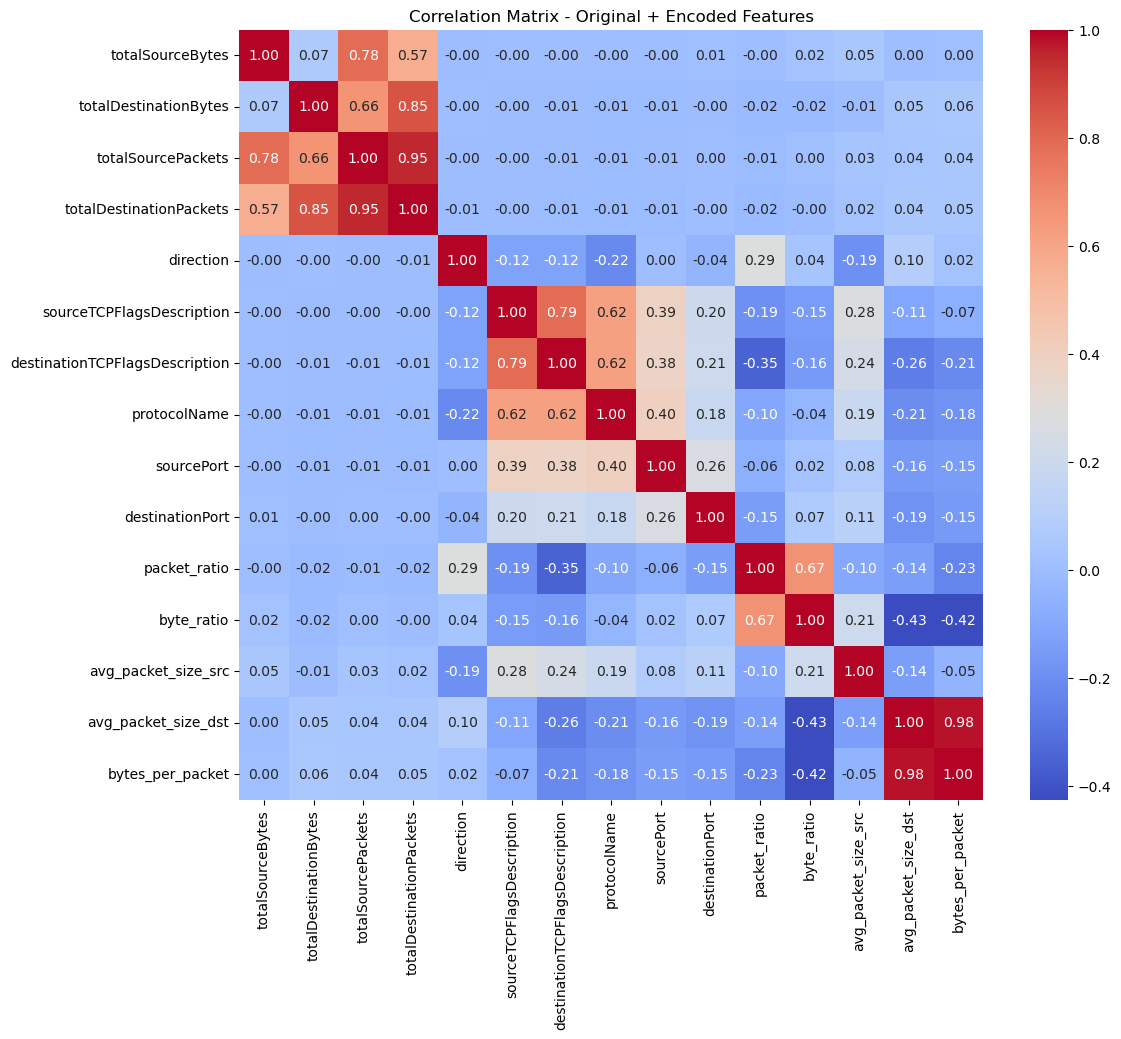

In [13]:
# Correlation matrix on original columns 
numeric_cols = df.select_dtypes(include=np.number)
corr_matrix = numeric_cols.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix - Original + Encoded Features")
plt.show()
corr_matrix.to_csv("eda_outputs/correlation_matrix_original.csv")

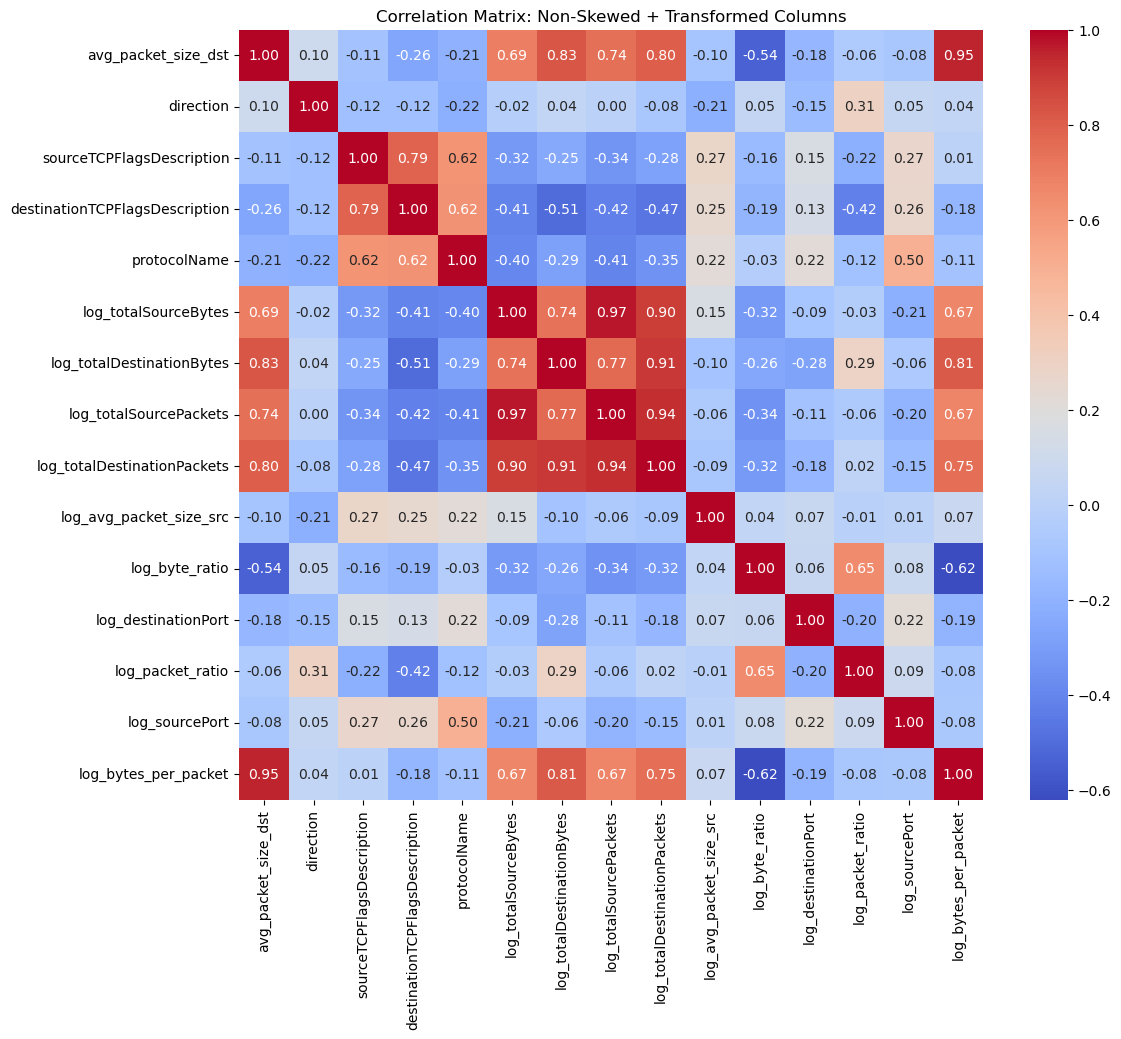

In [14]:
# Correlation matrix on skewed columns 
non_skewed_cols = [col for col in df_numeric.columns if col not in skewed_cols]
encoded_cols = ['direction','sourceTCPFlagsDescription','destinationTCPFlagsDescription','protocolName']
df_improved = df[non_skewed_cols+encoded_cols].copy()

# Add log-transformed versions of skewed columns
for col in transformed_cols:
    df_improved[f"log_{col}"] = np.log1p(df[col].clip(lower=0))

# Compute correlation matrix
corr_matrix_improved = df_improved.corr()

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_improved, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix: Non-Skewed + Transformed Columns")
plt.show()
corr_matrix_improved.to_csv("eda_outputs/correlation_matrix_improved.csv")



### Function to drop highly correlated columns

In [15]:
def drop_highly_correlated(df, threshold=0.95):
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find columns with correlation above threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    df_reduced = df.drop(columns=to_drop)

    print(f"Dropped {len(to_drop)} columns due to high correlation: {to_drop}")
    return df_reduced


In [16]:
# Apply to original dataset
df_numeric = df.select_dtypes(include=np.number)
df_reduced = drop_highly_correlated(df_numeric)
df_model_original = pd.concat([df_reduced, df["Label"]], axis=1)

Dropped 2 columns due to high correlation: ['totalDestinationPackets', 'bytes_per_packet']


In [17]:
# Apply to improved dataset
df_improved_numeric = df_improved.select_dtypes(include=np.number)
df_improved_reduced = drop_highly_correlated(df_improved_numeric)
df_model_improved = pd.concat([df_improved_reduced, df["Label"]], axis=1)

Dropped 2 columns due to high correlation: ['log_totalSourcePackets', 'log_bytes_per_packet']


## Train original dataset


=== SVM-RBF ===
Train Time: 1445.19s
Confusion Matrix:
[[39828   227]
 [   12  1366]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      1.00     40055
      Attack       0.86      0.99      0.92      1378

    accuracy                           0.99     41433
   macro avg       0.93      0.99      0.96     41433
weighted avg       0.99      0.99      0.99     41433


=== LinearSVC ===


C:\Users\sakab\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sakab\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Train Time: 59.91s
Confusion Matrix:
[[35298  4757]
 [  170  1208]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.88      0.93     40055
      Attack       0.20      0.88      0.33      1378

    accuracy                           0.88     41433
   macro avg       0.60      0.88      0.63     41433
weighted avg       0.97      0.88      0.91     41433


=== SGD-SVM ===
Train Time: 1.06s
Confusion Matrix:
[[36300  3755]
 [  158  1220]]
Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.91      0.95     40055
      Attack       0.25      0.89      0.38      1378

    accuracy                           0.91     41433
   macro avg       0.62      0.90      0.67     41433
weighted avg       0.97      0.91      0.93     41433


=== Model Performance Summary ===
    Model  Train Time (s)  Accuracy  Precision   Recall       F1      AUC
  SVM-RBF         1445.19  0.994232   0

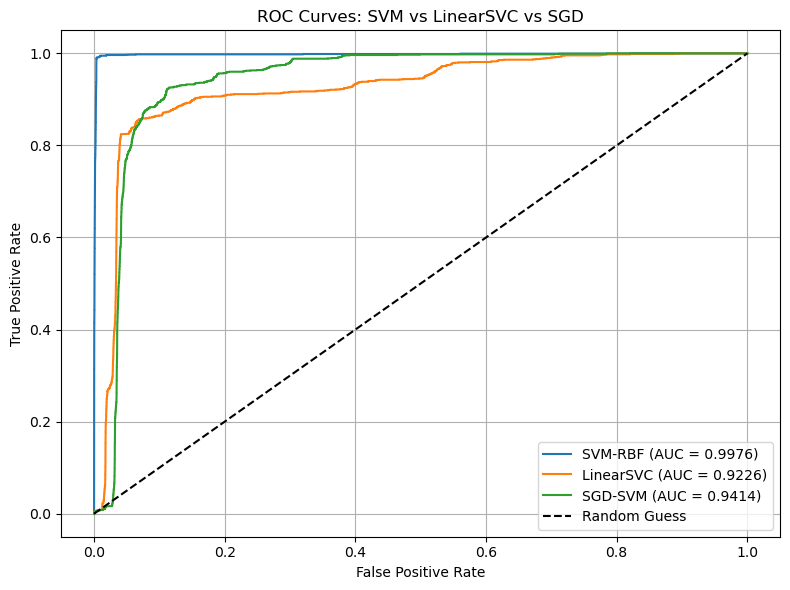

In [18]:
# === Data Prep ===
X = df_model_original.drop("Label", axis=1)
y = df_model_original["Label"].map({"Normal": 0, "Attack": 1})

# Reduce sample size for benchmarking
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.1, stratify=y, random_state=42)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, stratify=y_small, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# PCA for SVM
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# === Models ===
models = {
    "SVM-RBF": SVC(kernel='rbf', class_weight="balanced", probability=True, random_state=42),
    "LinearSVC": LinearSVC(class_weight="balanced", random_state=42),
    "SGD-SVM": SGDClassifier(loss="hinge", class_weight="balanced", random_state=42)
}

# === Storage ===
summary_results = []
roc_data = {}

# === Benchmark Loop ===
for name, model in models.items():
    print(f"\n=== {name} ===")
    start = time.time()

    if name == "SVM-RBF":
        model.fit(X_train_pca, y_train)
        y_pred = model.predict(X_test_pca)
        y_scores = model.predict_proba(X_test_pca)[:, 1]
    else:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        try:
            y_scores = model.decision_function(X_test_scaled)
        except:
            y_scores = model.predict_proba(X_test_scaled)[:, 1]

    end = time.time()
    train_time = end - start

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_scores)

    summary_results.append({
        "Model": name,
        "Train Time (s)": round(train_time, 2),
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1,
        "AUC": auc
    })

    # ROC data
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    roc_data[name] = (fpr, tpr, auc)

    # Diagnostics
    print(f"Train Time: {train_time:.2f}s")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["Normal", "Attack"]))

# === Summary Table ===
summary_df = pd.DataFrame(summary_results)
print("\n=== Model Performance Summary ===")
print(summary_df.to_string(index=False))

# === ROC Curve Plot ===
plt.figure(figsize=(8, 6))
for name, (fpr, tpr, auc_val) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_val:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves: SVM vs LinearSVC vs SGD")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
models = {
    'SVM-RBF': SVC(kernel='rbf', C=1.0, gamma='scale', class_weight='balanced', random_state=42),
    'LinearSVC': LinearSVC(class_weight='balanced', max_iter=5000, random_state=42),
    'SGD-SVM': SGDClassifier(loss='hinge', class_weight='balanced', max_iter=1000, tol=1e-3, random_state=42)
}

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc']

for name, model in models.items():
    print(f"\n=== {name} ===")
    start = time.time()
    cv_results = cross_validate(model, X_small, y_small, cv=5, scoring=scoring, return_train_score=True)
    print(f"CV Time: {time.time() - start:.2f} seconds")
    for metric in scoring:
        train_mean = cv_results[f'train_{metric}'].mean()
        test_mean = cv_results[f'test_{metric}'].mean()
        print(f"{metric.upper()} - Train: {train_mean:.4f}, Test: {test_mean:.4f}")


=== SVM-RBF ===
CV Time: 49356.21 seconds
ACCURACY - Train: 0.7513, Test: 0.7512
PRECISION_MACRO - Train: 0.5507, Test: 0.5507
RECALL_MACRO - Train: 0.8136, Test: 0.8135
F1_MACRO - Train: 0.5219, Test: 0.5218
ROC_AUC - Train: 0.8278, Test: 0.8276

=== LinearSVC ===


C:\Users\sakab\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sakab\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sakab\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
C:\Users\sakab\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sakab\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` expl

CV Time: 1499.69 seconds
ACCURACY - Train: 0.8349, Test: 0.8345
PRECISION_MACRO - Train: 0.5654, Test: 0.5650
RECALL_MACRO - Train: 0.7157, Test: 0.7145
F1_MACRO - Train: 0.5611, Test: 0.5605
ROC_AUC - Train: 0.6688, Test: 0.6697

=== SGD-SVM ===
CV Time: 8.73 seconds
ACCURACY - Train: 0.6193, Test: 0.6211
PRECISION_MACRO - Train: 0.5282, Test: 0.5291
RECALL_MACRO - Train: 0.6822, Test: 0.6880
F1_MACRO - Train: 0.4338, Test: 0.4355
ROC_AUC - Train: 0.7794, Test: 0.7836
